In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from asymopt.desc import  maxminscale,process_desc
from asymopt.ml import model_delta_pred
from rdkit import Chem
import pandas as pd
from asymopt.desc import getmorganfp
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
import numpy as np

In [2]:
# load morgan fingerprint
lit_fp_arr = np.load("../descriptor/lit_fp_arr.npy")
com_fp_arr = np.load("../descriptor/com_fp_arr.npy")
fp_map = {"morgan":[lit_fp_arr,com_fp_arr],"atompair":[],"topological":[]}

In [3]:
# generate other type fingerprints
lit_data = pd.read_csv("../data/processed/lit_data_with_cplex_smi.csv")
lit_complex_smi_lst = lit_data["complex_smi"].to_list()
lit_complex_lst = [Chem.MolFromSmiles(smi) for smi in lit_complex_smi_lst]

com_data = pd.read_csv("../data/processed/com_data_with_cplex_smi.csv")
com_complex_smi_lst = com_data["complex_smi"].to_list()
com_complex_lst = [Chem.MolFromSmiles(smi) for smi in com_complex_smi_lst]

fp_type_lst = ["topological", "atompair"]
for fp_type in fp_type_lst:
    lit_complex_fp_lst = []
    com_complex_fp_lst = []
    for mol in tqdm(lit_complex_lst):
        Chem.SanitizeMol(mol)
        fp = getmorganfp(mol,fp_type=fp_type)
        lit_complex_fp_lst.append(fp)
    for mol in tqdm(com_complex_lst):
        Chem.SanitizeMol(mol)
        fp = getmorganfp(mol,fp_type=fp_type)
        com_complex_fp_lst.append(fp)
    lit_complex_fp_arr = np.array(lit_complex_fp_lst)
    com_complex_fp_arr = np.array(com_complex_fp_lst)
    merg_complex_fp_arr = maxminscale(process_desc(np.concatenate([lit_complex_fp_arr,com_complex_fp_arr],axis=0)))
    lit_fp_arr = merg_complex_fp_arr[:len(lit_complex_fp_arr)]
    com_fp_arr = merg_complex_fp_arr[len(lit_complex_fp_arr):]
    fp_map[fp_type] = [lit_fp_arr,com_fp_arr]

100%|██████████| 21/21 [00:00<00:00, 126.59it/s]


In [4]:
com_df = pd.read_csv('../data/processed/com_data.csv')
lit_df = pd.read_csv('../data/processed/lit_data_with_cplex_smi.csv')
l_rct1_smi_lst,l_rct2_smi_lst,l_metal_lst,l_lig_smi_lst,l_tgt = lit_df['rct_1_smi'].to_list(),lit_df['rct_2_smi'].to_list(),lit_df['metal'].to_list(),lit_df['lig_smi'].to_list(),lit_df['ddG'].to_numpy()
c_rct1_smi_lst,c_rct2_smi_lst,c_metal_lst,c_lig_smi_lst,c_tgt = com_df['rct_1_smi'].to_list(),com_df['rct_2_smi'].to_list(),com_df['metal'].to_list(),com_df['lig_smi'].to_list(),com_df['ddG'].to_numpy()
com_rdkit_arr = np.load("../descriptor/com_rdkit_arr.npy",allow_pickle=True)
lit_rdkit_arr = np.load("../descriptor/lit_rdkit_arr.npy",allow_pickle=True)

In [7]:
model = DecisionTreeRegressor(random_state=0)
dist_types = ["euclidean","manhattan","tanimoto","cosine"]
fp_types = list(fp_map.keys())
res_map = {}
for fp_type in fp_types:
    for dist_type in dist_types:
        lit_fp_arr,com_fp_arr = fp_map[fp_type]
        all_test_y,all_test_p,com_r2,com_mae,com_prsr = model_delta_pred(com_fp_arr,
                                                                        c_tgt,
                                                                        lit_fp_arr,
                                                                        l_tgt,
                                                                        model,
                                                                        simi=True,
                                                                        dist_type=dist_type,
                                                                        topk=0.4,
                                                                        tgt_simi_desc=com_rdkit_arr,
                                                                        base_simi_desc=lit_rdkit_arr,
                                                                        ret_metrics=True)
        print(f"{fp_type} {dist_type} R2:{com_r2} MAE:{com_mae} PearsonR:{com_prsr}")
        res_map[(fp_type,dist_type)] = [com_r2,com_mae,com_prsr]

morgan euclidean R2:0.6296163515493429 MAE:0.10708373615928114 PearsonR:0.8107600516288229
morgan manhattan R2:-0.36272719599396974 MAE:0.20032870770313108 PearsonR:0.39259310222395494
morgan tanimoto R2:0.2791718938081301 MAE:0.14020273568537264 PearsonR:0.6619227528876861
morgan cosine R2:-0.4190761224331483 MAE:0.18098160685098552 PearsonR:0.2716189329132504
atompair euclidean R2:-2.8017907065962513 MAE:0.35646893219294756 PearsonR:0.00933197414764112
atompair manhattan R2:-1.5386307736452234 MAE:0.2480471655361657 PearsonR:0.47766471489263707
atompair tanimoto R2:-4.1563860447167515 MAE:0.33730522254035666 PearsonR:0.007801660968383292
atompair cosine R2:-4.443432112647405 MAE:0.3534813231980348 PearsonR:-0.08892155409390659
topological euclidean R2:0.0416689531591079 MAE:0.18690049490813282 PearsonR:0.5280761138590075
topological manhattan R2:0.2551005598078302 MAE:0.1680210332391502 PearsonR:0.7160517284932628
topological tanimoto R2:0.10532863114159574 MAE:0.18368667647614967 Pe

<Axes: >

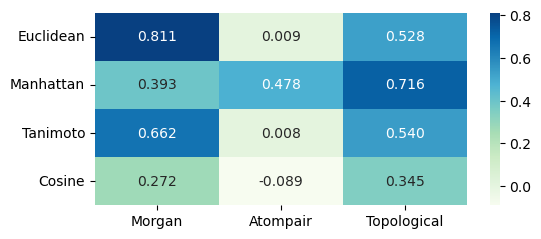

In [10]:
res_prsr_map = np.zeros((len(dist_types),len(fp_types)))
for i,dist_type in enumerate(dist_types):
    for j,fp_type in enumerate(fp_types):
        res_prsr_map[i,j] = res_map[(fp_type,dist_type)][2]

plt.figure(figsize=(6,2.5))
sns.heatmap(res_prsr_map,cmap='GnBu',annot=True,fmt='.3f',xticklabels=[name.capitalize() for name in fp_types],yticklabels=[name.capitalize() for name in dist_types])

<Axes: >

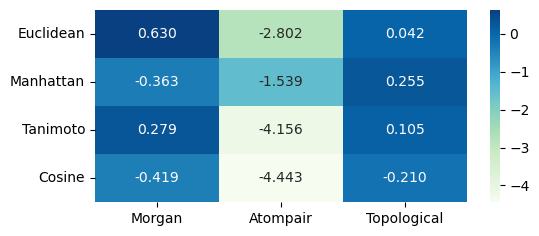

In [11]:
res_prsr_map = np.zeros((len(dist_types),len(fp_types)))
for i,dist_type in enumerate(dist_types):
    for j,fp_type in enumerate(fp_types):
        res_prsr_map[i,j] = res_map[(fp_type,dist_type)][0]

plt.figure(figsize=(6,2.5))
sns.heatmap(res_prsr_map,cmap='GnBu',annot=True,fmt='.3f',xticklabels=[name.capitalize() for name in fp_types],yticklabels=[name.capitalize() for name in dist_types])